# Большая лабораторная

## Постановка задачи
Постановка задачи.
На вход могу приходить фотографии только одного фиксированного стула и одного фиксированного дверного проема. Для другого стула или другого дверного проема алгоритм будет сообщать о некорректности входных данных. Также необходимо задать аргументы для работы алгоритма (все данные задаются в метрах):

- расстояние от дверного проема до точки съемки
- высота от пола, на которой была расположена камера во время съемки
- расстояние от дверного проема до ближайшей точки стула

Для более точной работы алгоритма пользователь может задать аргументы:
- высота от пола до сидения стула
- высота от пола до верхней точки спинки
- ширина сидения стула
- ширина дверного проема
- высота дверного проема

На выходе алгоритм должен по фотографии определить можно ли стул, не изменяя его положения, пронести через дверного проем. Ответить можно или нет. Также, опционально, сообщить о нарушении входных требований. 

Требования к входному изображению:
- формат .jpg
- на фотографии обязательно должны присутствовать стул и дверной проем
- стул не может быть перекрыт никаким объектом
- фотография должна быть сделана не дальше 4 метров от двери
- на фотографии должны быть полностью видны стул и дверь

## План
1. Детектирование стула и дверного проема
1.1 Для поиска границ дверного проема стоит применить преобразование Хафа для поиска прямых на изображение, поскольку дверной проем представляет собой прямоугольник.
1.2 Для поиска границ стула можно использовать метод Канни, но для своей работы он требует подбор параметров, поэтому чтобы не заниматься этим подбором можно применить метод Smooth countour detection (см. статью http://www.ipol.im/pub/art/2016/175/)
2. Определение найденных объектов
После того как границы некоторых объектов были найдены требуется понять те ли это объекты, которые мы хотели обнаружить, и как они расположены друг относительно друга.
Для этого требуется сопоставить особые точки изображение с объектами на шаблонах стула и дверного проема (особые размеченные изображения с вырезанными стулом и дверным проемом без лишних объектов). Например применить детекторы углов(https://habr.com/ru/post/244541/), дескрипторы SIFT(http://www.ipol.im/pub/art/2014/82/), BRIEF, SURF. Для сравнения применить метод FLANN .
3. Если на изображении были распознаны дверной проем и стул, то при помощи входных параметров, заданных пользователем, приводим стул и дверной проем к единому масштабу.
4. Ответ на вопрос "Проходит ли стул в дверь в положении, как на фотографии". Сравнить полученные размеры стула и дверного проема.
5. *Определение угла, на который нужно повернуть стул, чтобы он прошел в дверной проем.

In [240]:
from skimage.feature import canny
from skimage.filters import sobel, gaussian
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from imageio import imread, imsave
from skimage.color import rgb2gray
import numpy as np
from skimage.feature import canny
from skimage.filters import try_all_threshold
from skimage.filters import gaussian
from skimage.filters import threshold_otsu, rank
from skimage.filters import threshold_triangle
from skimage.morphology import disk
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.util import img_as_ubyte
from skimage.transform import hough_line, hough_line_peaks
import cv2
from scipy.ndimage.morphology import binary_fill_holes
from matplotlib.patches import Rectangle

По высоте стул проходит в дверь при любом положени, этому достаточно определить ее ширину.

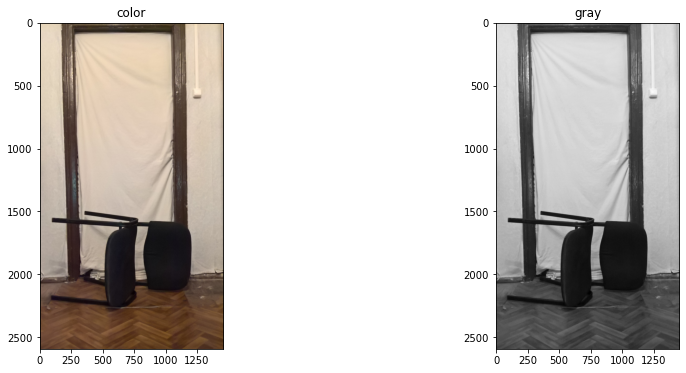

In [252]:
chair = imread("data/chair11.jpg")
chair_door = imread("data/chair_door06.jpg")
chair_door_gray = rgb2gray(chair_door)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title('color')
ax[0].imshow(chair_door)
ax[1].set_title('gray')
ax[1].imshow(chair_door_gray, cmap='gray')

203.7139094273873
1165.111660000236
299.7633399491228
283.7551015288337
244.7350203793787
229.7272968603576
1067.1582692217382
303.93367399396936
1066.0911947103173


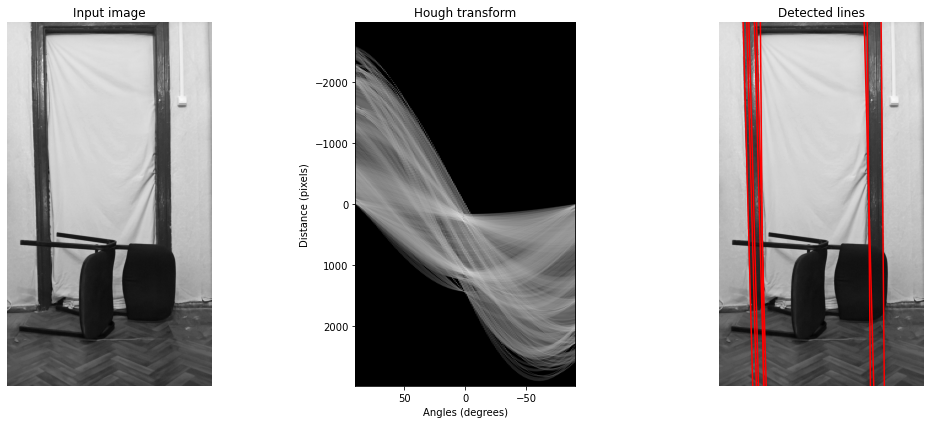

In [242]:
h, theta, d = hough_line(canny(chair_door_gray))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

ax[0].imshow(chair_door_gray, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap='gray', aspect=1/20)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[2].imshow(chair_door_gray, cmap="gray")
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - chair_door_gray.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, chair_door_gray.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, chair_door_gray.shape[1]))
ax[2].set_ylim((chair_door_gray.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

В качестве ширины двери можно взять расстояние между двумя вертикальными прямыми, или близкими к вертикали, которые находятся ближе всего к середине.

In [243]:
import math
right_min = 100000
left_max = 0
h_shape, w_shape = chair_door_gray.shape
w_half = math.floor(w_shape / 2)
h_half = math.floor(h_shape / 2)
ax[1].imshow(chair_door_gray, cmap="gray")
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - chair_door_gray.shape[1] * np.cos(angle)) / np.sin(angle)
    if(abs(y0-y1) > 10000): #проверка на почти вертикальность
        x = (((h_half - y0) * w_shape) / (y1 - y0))
        if(x > w_half and x < right_min):
            right_min = x
        elif (x < w_half and x > left_max):
            left_max = x
print(right_min)
print(left_max)
door_width = right_min-left_max
print("door width = ", door_width)

1066.0911947103173
303.93367399396936
door width =  762.1575207163479


Теперь нужно найти ширину которую занимает стул. Возьмем стул сфотографированный отдельно в похожем положении.

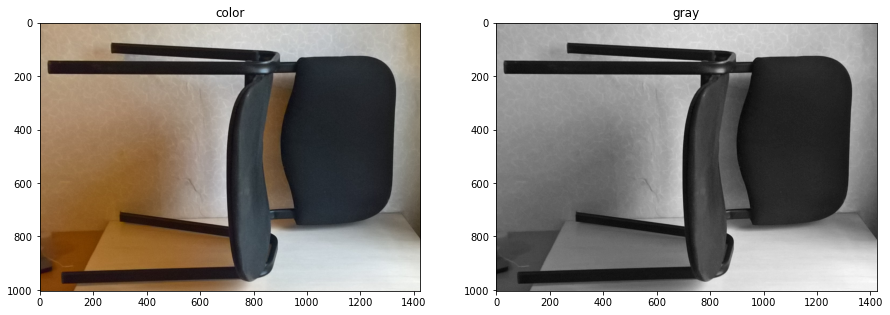

In [244]:

chair_gray = rgb2gray(chair)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title('color')
ax[0].imshow(chair)
ax[1].set_title('gray')
ax[1].imshow(chair_gray, cmap='gray')

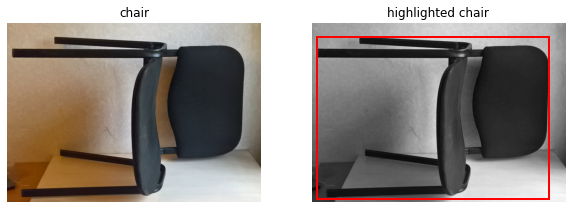

In [245]:
from skimage.filters import threshold_triangle

chair_gray = cv2.cvtColor(chair , cv2.COLOR_BGR2GRAY)
def obj_border(image):
    edge_map = binary_closing(canny(image, sigma=1), selem=np.ones((12,12)))
    mask = binary_fill_holes(edge_map)
    mask = binary_opening(mask, selem=np.ones((12, 12)))
    vertical_indices = np.where(np.any(mask, axis=1))[0]
    top = vertical_indices[0]
    bottom = vertical_indices[-1]
    horizontal_indices = np.where(np.any(mask, axis=0))[0]
    left = horizontal_indices[0]
    right = horizontal_indices[-1]
    return Rectangle((left, top), right - left, bottom - top, linewidth=2, edgecolor='r', facecolor='none')
chair_border = obj_border(chair_gray)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].set_title('chair')
ax[0].axis('off')
ax[0].imshow(chair)

ax[1].set_title('highlighted chair')
ax[1].axis('off')
ax[1].imshow(chair_gray, cmap='gray')
ax[1].add_patch(chair_border)

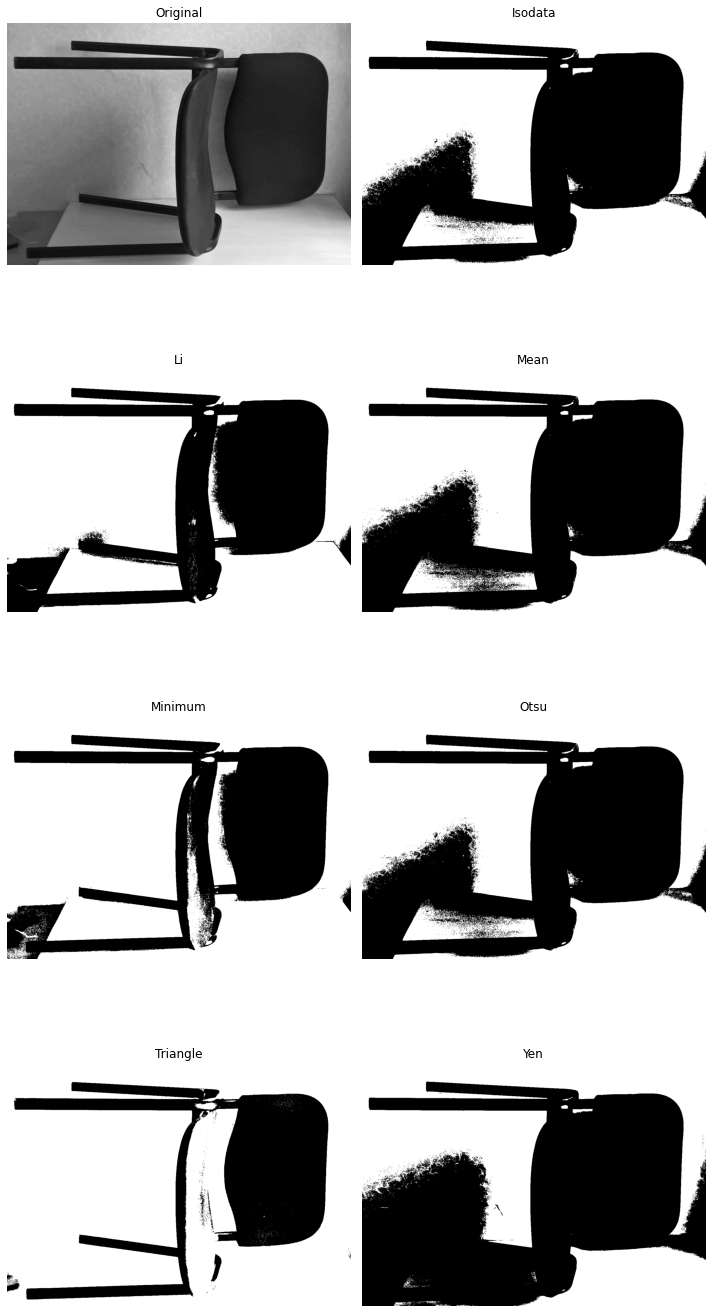

In [246]:
fig, ax = try_all_threshold(rgb2gray(chair), figsize=(10, 20), verbose=False)
plt.show()

In [247]:
def inpaint(originalImage, mask):
    [rows, columns, channels] = originalImage.shape
    result = np.zeros((rows,columns,channels))
    for row in range(rows):
        for column in range(columns):
            if(mask[row,column]==1):
                originalImage[row,column] = (255,255,255)
    return originalImage

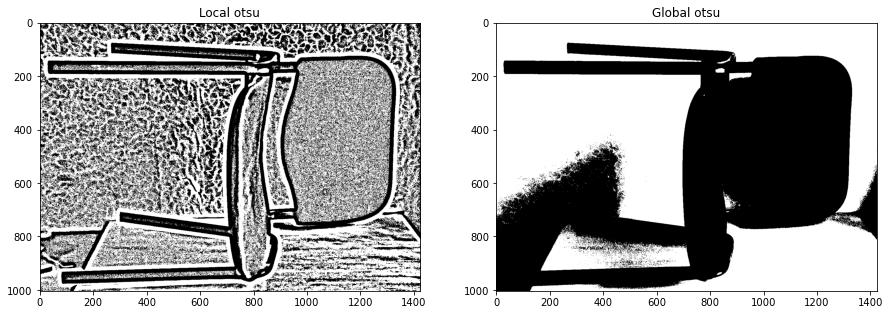

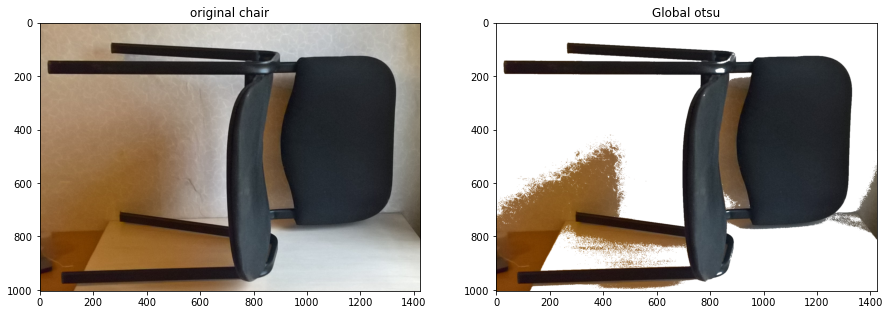

In [248]:
# chair = cv2.imread("chair11.jpg")
data_img_gray = rgb2gray(chair)
img = img_as_ubyte(data_img_gray)
radius = 15
selem = disk(radius)
local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu


img_local_otsu = img >= local_otsu
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title('Local otsu')
ax[0].imshow(img_local_otsu, cmap='gray')
ax[1].set_title('Global otsu')
ax[1].imshow(global_otsu, cmap='gray')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].set_title('original chair')
ax[0].imshow(chair, cmap='gray')


chair = inpaint(chair, global_otsu)


ax[1].set_title('Global otsu')
ax[1].imshow(chair, cmap='gray')
plt.show()


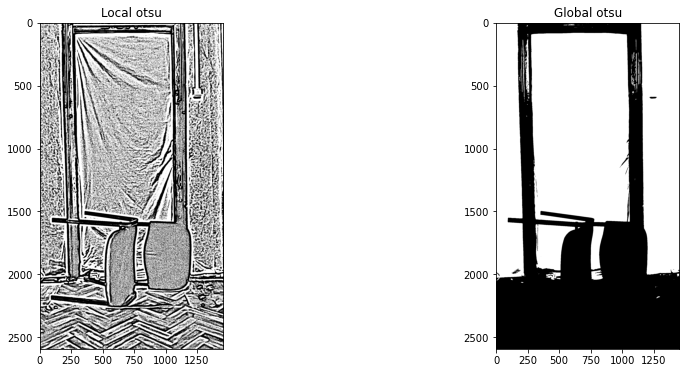

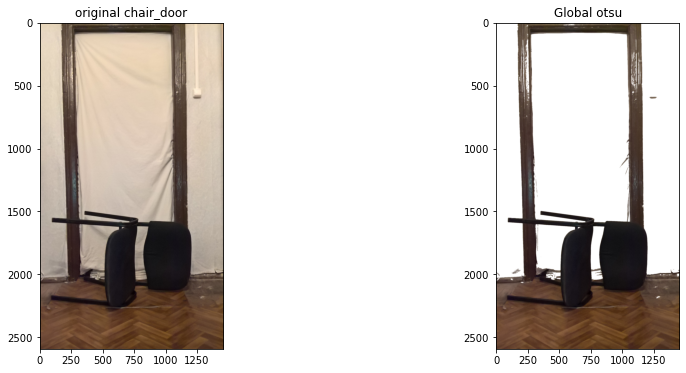

In [249]:
# chair_door = cv2.imread("chair_door06.jpg")
data_img_gray = rgb2gray(chair_door)
img = img_as_ubyte(data_img_gray)
radius = 15
selem = disk(radius)
local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

img_local_otsu = img >= local_otsu
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title('Local otsu')
ax[0].imshow(img_local_otsu, cmap='gray')
ax[1].set_title('Global otsu')
ax[1].imshow(global_otsu, cmap='gray')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].set_title('original chair_door')
ax[0].imshow(chair_door, cmap='gray')


chair_door = inpaint(chair_door, global_otsu)

ax[1].set_title('Global otsu')
ax[1].imshow(chair_door, cmap='gray')
plt.show()

По особым точкам необходимо детектировать стул на изображении с дверью.

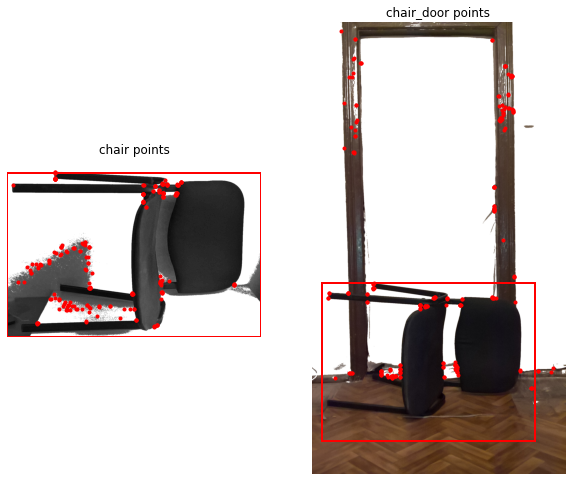

In [250]:
chair_gray = cv2.cvtColor(chair , cv2.COLOR_BGR2GRAY)
chair_door_gray = cv2.cvtColor(chair_door, cv2.COLOR_BGR2GRAY)                   

orb = cv2.ORB_create(500)

keypoints1 = orb.detect(chair_gray, None)
keypoints2 = orb.detect(chair_door_gray, None)

keypoints1, des1 = orb.compute(chair_gray, keypoints1)
keypoints2, des2 = orb.compute(chair_door_gray, keypoints2)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

obj = np.zeros((len(matches), 2))
scene = np.zeros((len(matches), 2))

for i in range(len(matches)):
    obj[i,:] = keypoints1[ matches[i].queryIdx ].pt
    scene[i,:] = keypoints2[ matches[i].trainIdx ].pt
    
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title('chair points')
ax[0].axis('off')
ax[0].imshow(chair_gray, cmap='gray')
ax[0].plot(obj[:,0], obj[:,1], ".", color='red')

ax[1].set_title('chair_door points')
ax[1].axis('off')
ax[1].imshow(chair_door, cmap='gray')
ax[1].plot(scene[:,0], scene[:,1], ".", color='red')
    
    
homography, mask = cv2.findHomography(obj, scene, cv2.RANSAC)
height, width = chair_door_gray.shape
transformed = cv2.warpPerspective(chair_gray, homography, (width, height))

ax[0].axis('off')
border = obj_border(chair_gray)
ax[0].add_patch(border)
ax[1].axis('off')
transformed_border = obj_border(transformed)
ax[1].add_patch(transformed_border)

plt.show()


Из-за теней от стула и слишком темного пола не получается точно сопоставить особые точки, поэтому прямоугольник получается не минимальный.

Сравним ширину прямоугольника с шириной двери.

In [251]:
if (transformed_border.get_width() > door_width):
    print("Стул не проходит в дверь")
else:
    print("Стул проходит в дверь")
    

Стул не проходит в дверь
